In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML

sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 1000)

In [2]:
nh = 8
refRatio = 2
c = 1.
t = 0.2

This cell initializes some example AMR grid.

['$a_{0}$' '$a_{1}$sin2$\\pi$' '$a_{2}$cos2$\\pi$' '$a_{3}$sin4$\\pi$' '$a_{4}$cos4$\\pi$' '$a_{5}$sin6$\\pi$' '$a_{6}$cos6$\\pi$' '$a_{7}$sin8$\\pi$' '$a_{8}$cos8$\\pi$' '$a_{9}$sin10$\\pi$' '$a_{10}$cos10$\\pi$' '$a_{11}$sin12$\\pi$' '$a_{12}$cos12$\\pi$' '$a_{13}$sin14$\\pi$' '$a_{14}$cos14$\\pi$' '$a_{15}$sin16$\\pi$']
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


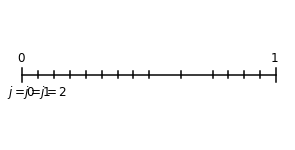

In [3]:
ct = c * t

cells = [[0, 1, 2, 3, 6, 7]] #, 3], [0, 1, 6, 7]]#, [0, 1, 2]] # [[1], [2], [4, 5], [8, 9, 11]] #, [16, 17, 19, 22]]
omega = BT.Grid(nh)
omega.AddPatch(refRatio, cells[0])
print(omega.strings)
# for i in cells:
#     print('now', omega.levels)
#
#     print('refRatios:', omega.refRatios)
#     print('nh:', omega.nh)
#     print(omega.xPatches)
#     print(omega.patches)
#     print(omega.strings)
PT.PlotGrid(omega)

This cell computes the node-centered and cell-centered modes of the `omega` grid object and then plots them.

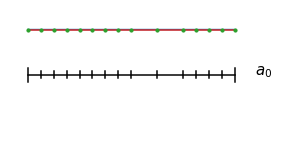

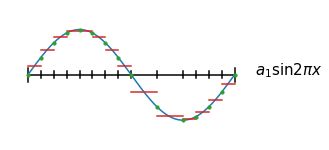

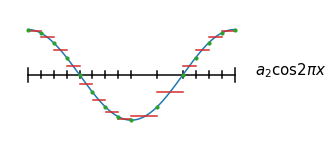

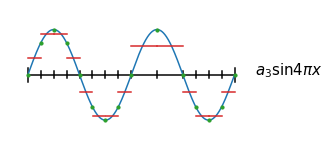

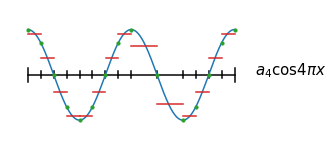

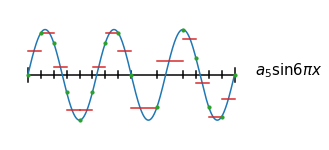

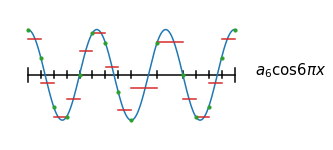

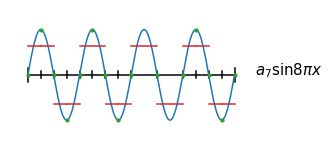

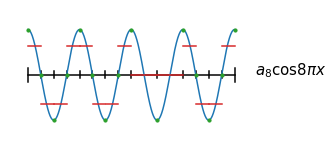

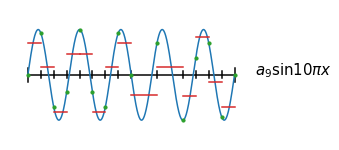

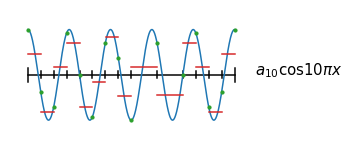

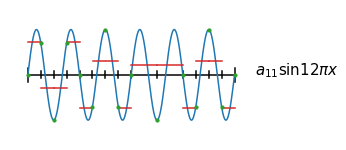

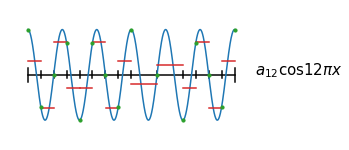

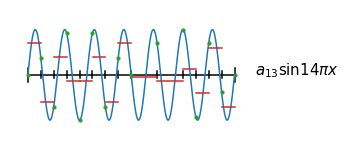

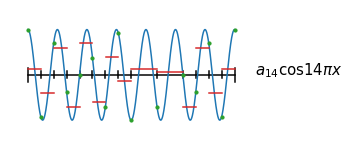

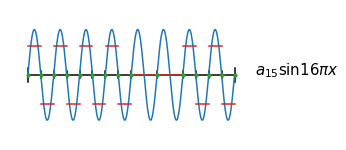

In [4]:
waves = WT.MakeWaves(omega)
# print(omega.nh[::-1][0], omega.degFreed[::-1][0], len(waves[0, :]), len(waves[:, 0]))
wavesNode = WT.MakeNodeWaves(omega)
PT.PlotWaves(omega, waves = waves, waveNode = wavesNode)
# print(waves)

This cell finds our waves which alias to zero on the coarse grid.

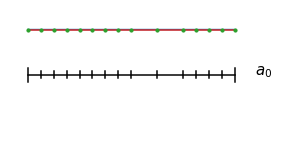

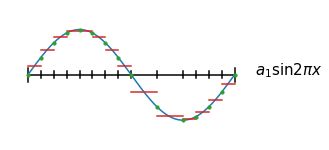

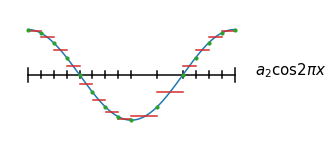

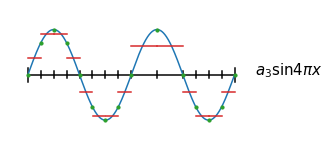

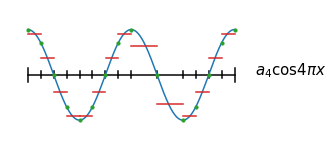

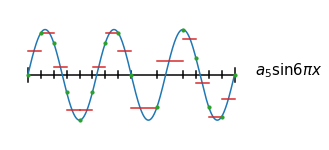

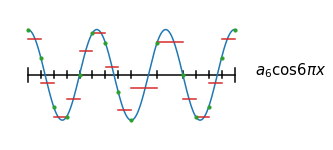

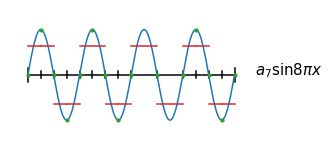

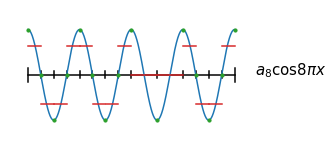

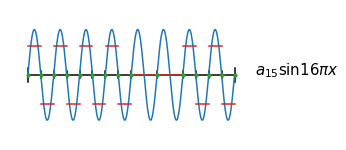

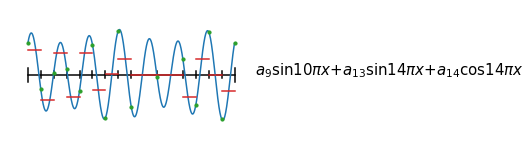

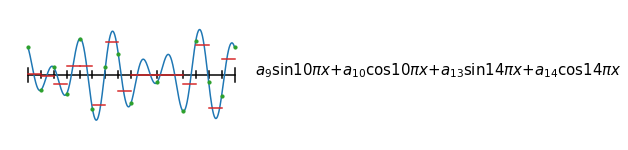

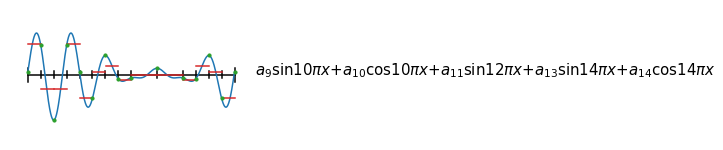

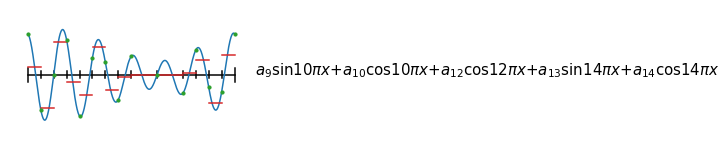

In [5]:
nullspace = OT.FindNullspace(omega, waves)
# print('nullspace')
# print(nullspace)
# print('nullspace')
newMat = nullspace + 0
newMat[0][0] = 0
# print(newMat[:-1])
PT.PlotWaves(omega, waves, waveNode = wavesNode, nullspace = nullspace)

In [11]:
print(nullspace)

[[ 1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.70710678  0.          0.          0.          0.          0.        

To go from fine to coarse, the term would be averaging down. For example, it would 0.5:0.5 for a refinement ratio of 2. This is exact for finite-volume.

To go from coarse to fine, there are two options. Piecewise constant, and piecewise linear. The piecewise linear takes neighboring values to interpolate to fine cell averages. advection

[4, 8]
[4, 8, 16]
[4, 8, 16, 32]
[4, 8, 16, 32, 64]


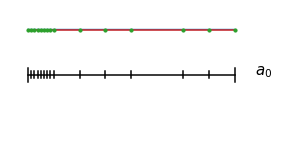

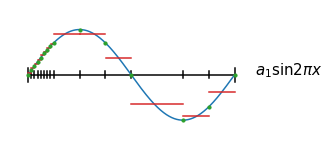

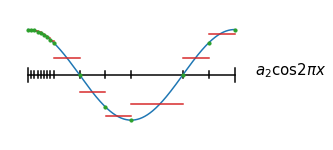

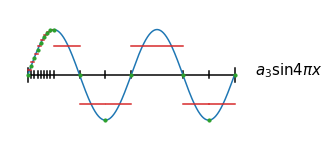

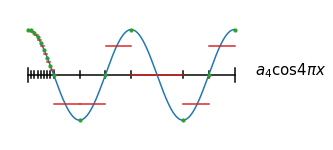

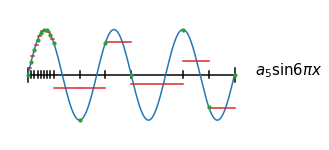

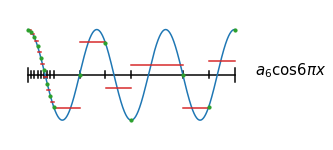

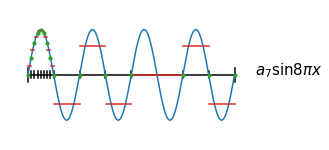

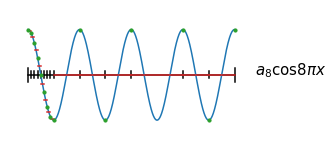

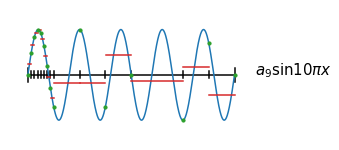

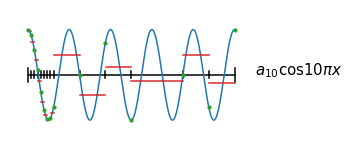

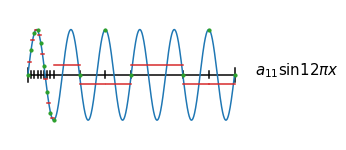

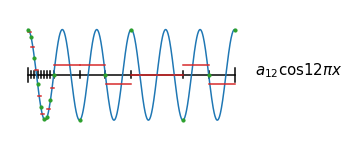

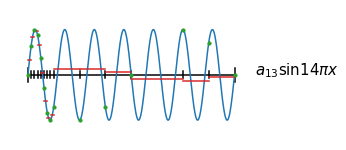

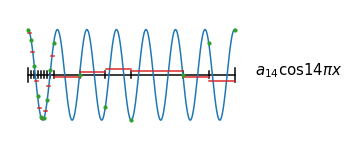

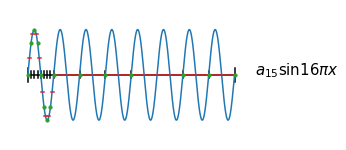

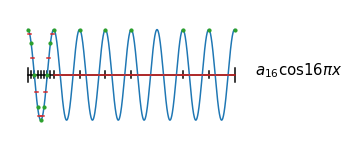

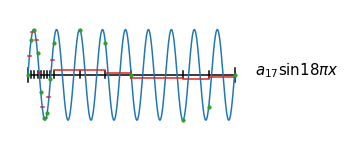

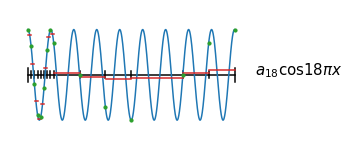

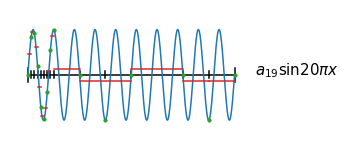

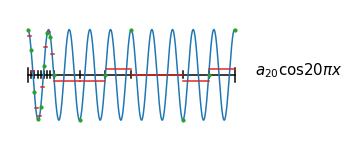

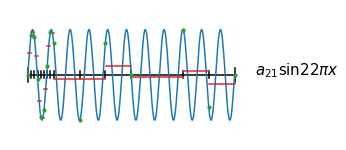

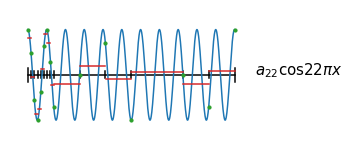

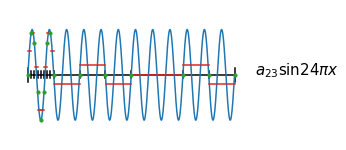

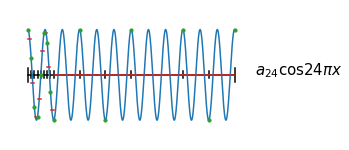

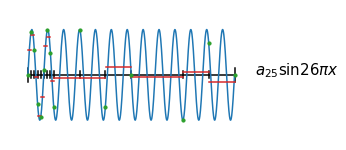

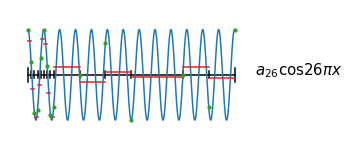

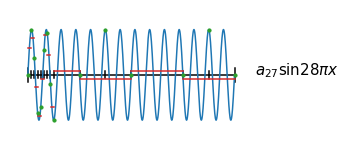

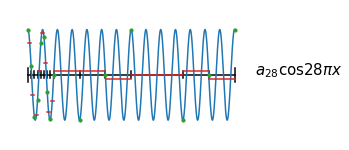

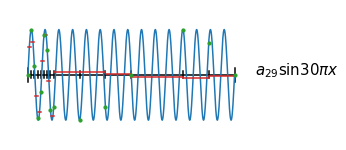

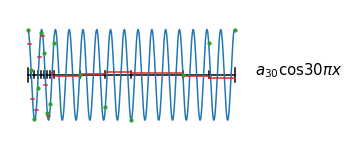

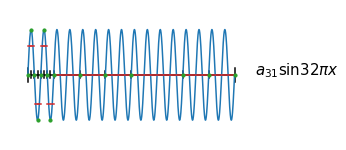

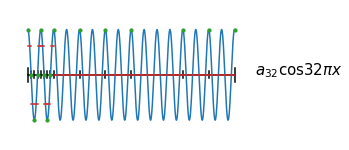

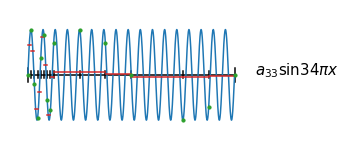

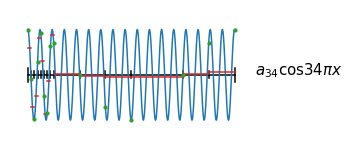

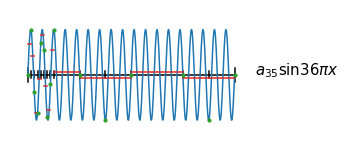

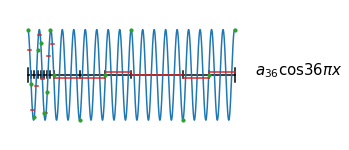

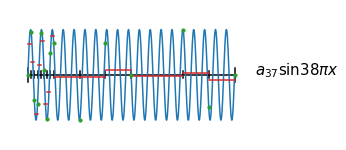

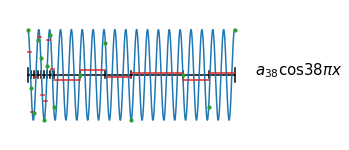

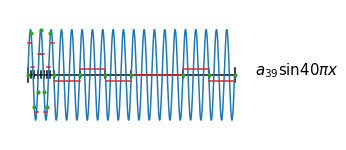

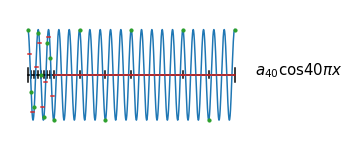

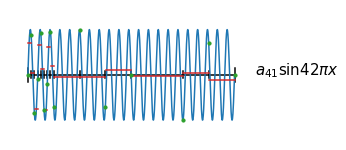

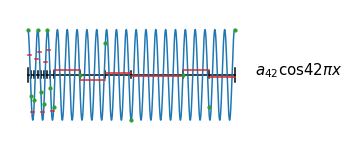

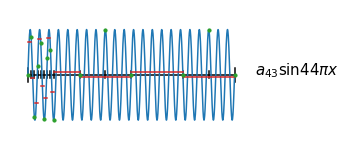

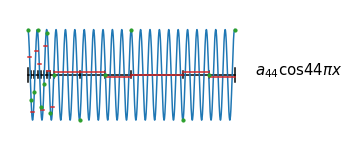

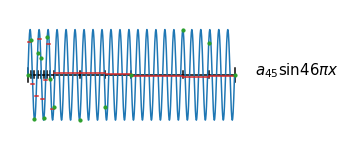

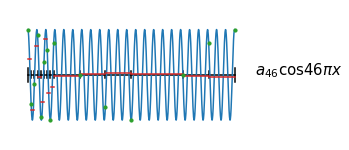

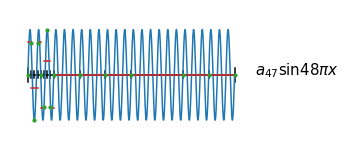

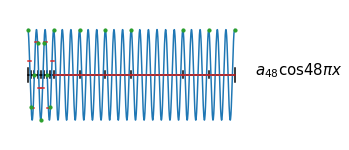

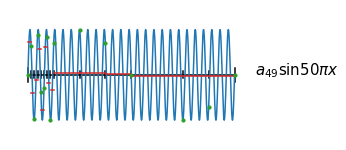

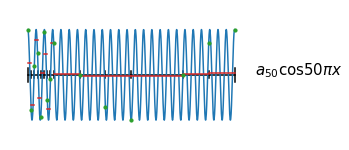

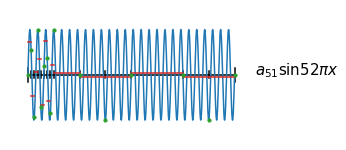

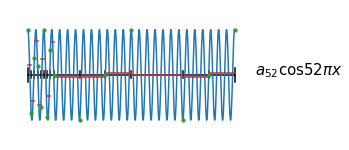

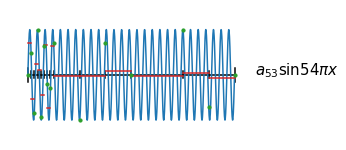

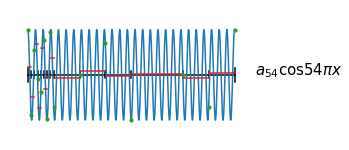

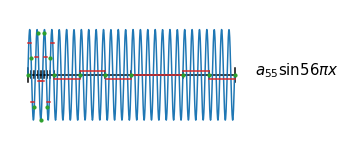

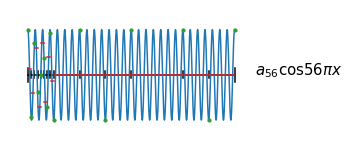

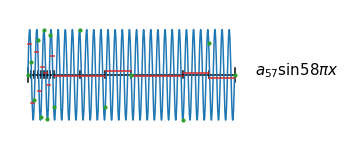

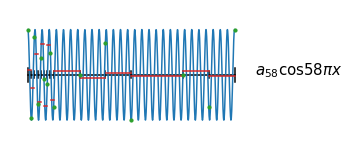

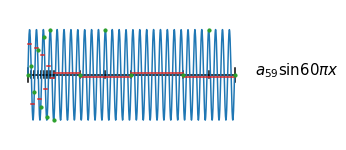

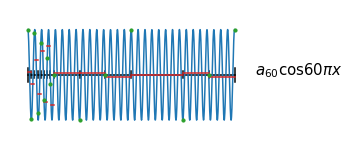

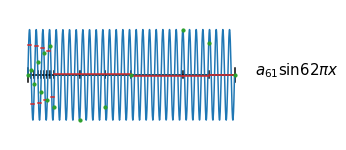

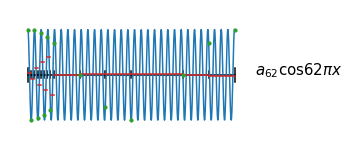

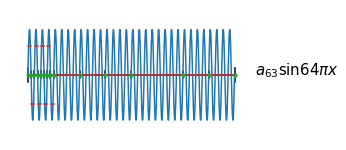

[[ 1.00000000e+00  4.90479714e-02  9.98394393e-01  9.78597633e-02  9.93586851e-01  1.46200713e-01  9.85605147e-01  1.93839179e-01  9.74495358e-01  2.40548025e-01  9.60321547e-01  2.86106072e-01  9.43165321e-01  3.30299505e-01  9.23125276e-01  3.72923229e-01  9.00316316e-01  4.13782159e-01  8.74868869e-01  4.52692443e-01  8.46927993e-01  4.89482602e-01  8.16652385e-01  5.23994577e-01  7.84213304e-01  5.56084686e-01  7.49793401e-01  5.85624475e-01  7.13585488e-01  6.12501464e-01  6.75791226e-01  6.36619772e-01  6.36619772e-01  6.57900632e-01  5.96286376e-01  6.76282781e-01  5.55010935e-01  6.91722726e-01  5.13016538e-01  7.04194890e-01  4.70527982e-01  7.13691623e-01  4.27770297e-01  7.20223104e-01  3.84967269e-01  7.23817099e-01  3.42339992e-01  7.24518620e-01  3.00105439e-01  7.22389447e-01  2.58475077e-01  7.17507549e-01  2.17653536e-01  7.09966392e-01  1.77837323e-01  6.99874143e-01  1.39213623e-01  6.87352779e-01  1.01959153e-01  6.72537106e-01  6.62391234e-02  6.55573701e-01
   3.2

In [6]:
cells = [[0, 1, 3], [0], [0, 1], [0, 1, 2, 3]] # [[1], [2], [4, 5], [8, 9, 11]] #, [16, 17, 19, 22]]
omega2 = BT.Grid(4)
for i in cells:
    omega2.AddPatch(refRatio, i)
    print(omega2.nh)

waves = WT.MakeWaves(omega2)
wavesNode = WT.MakeNodeWaves(omega2)
PT.PlotWaves(omega2, waves, waveNode = wavesNode)
print(waves)


[[ 1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.70710678  0.          0.          0.          0.          0.       

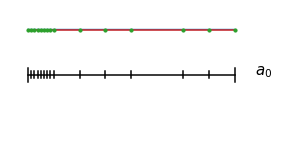

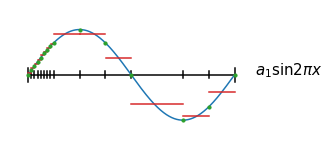

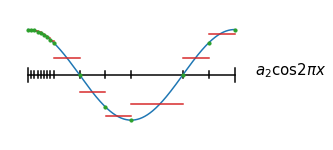

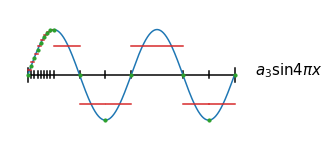

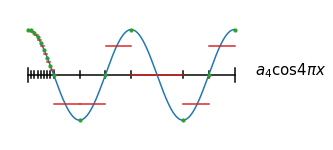

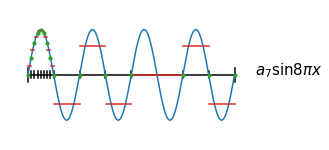

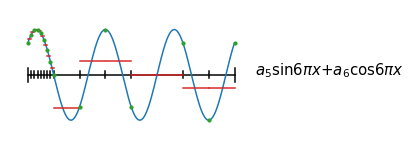

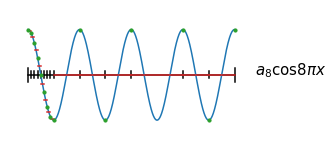

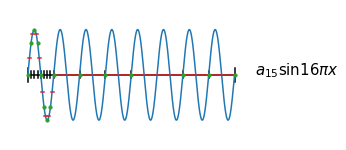

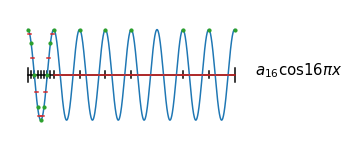

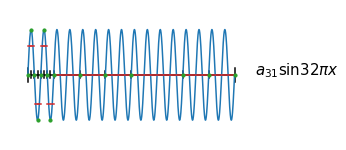

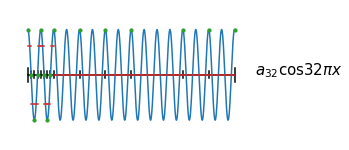

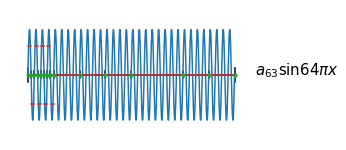

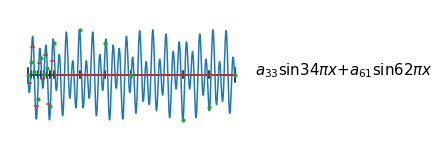

In [7]:
nullspace = OT.FindNullspace(omega2, waves)
print('')
print(nullspace)
PT.PlotWaves(omega2, waves, waveNode = wavesNode, nullspace = nullspace)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


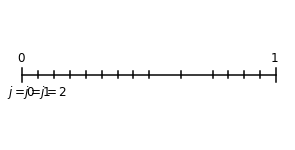

This image has been saved under /Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/Grid.


In [8]:
PT.PlotGrid(omega, save = True)

In [9]:
blah = ''
print('look' + blah + 'look')

looklook


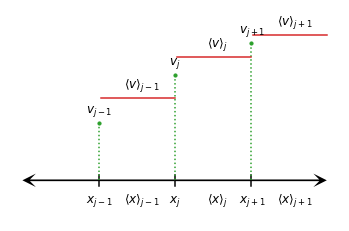

This image has been saved under /Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/DivergenceVisual.


In [10]:
PT.DivergVis(save = True)
